In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.measure import label
from skimage.color import label2rgb

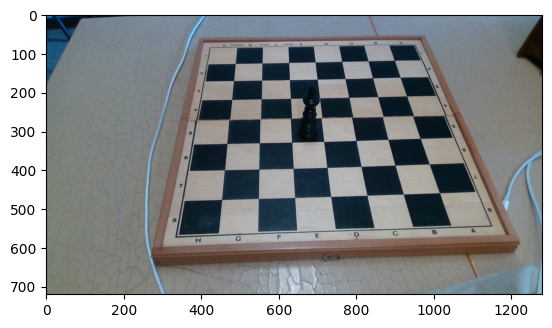

In [2]:
img = cv2.imread("rs/color.png", cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

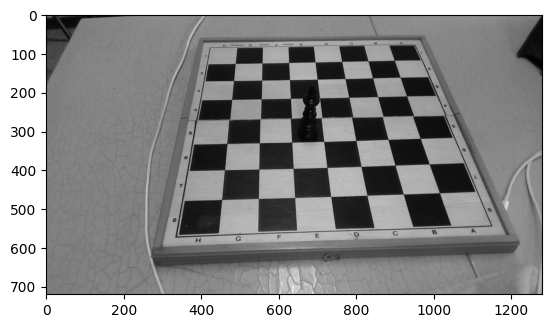

In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap="gray")

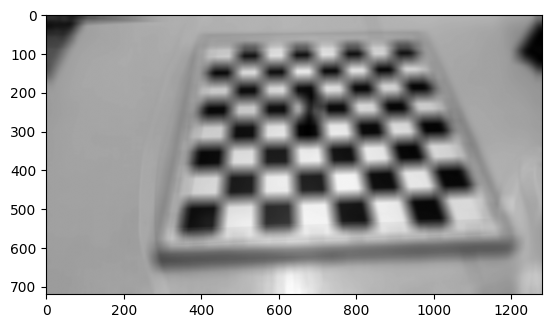

In [4]:
blur_amount = 40
blurred = cv2.blur(gray,(blur_amount, blur_amount))
plt.imshow(blurred, cmap="gray")

array([[0.25      , 0.25      , 0.25      , ..., 0.51041667, 0.51041667,
        0.51041667],
       [0.25      , 0.25      , 0.25      , ..., 0.51041667, 0.51041667,
        0.51041667],
       [0.25      , 0.25      , 0.25      , ..., 0.51041667, 0.51041667,
        0.51041667],
       ...,
       [0.640625  , 0.640625  , 0.640625  , ..., 0.75      , 0.75      ,
        0.75      ],
       [0.640625  , 0.640625  , 0.640625  , ..., 0.75      , 0.75      ,
        0.75      ],
       [0.640625  , 0.640625  , 0.640625  , ..., 0.75      , 0.74479167,
        0.74479167]], shape=(720, 1280))

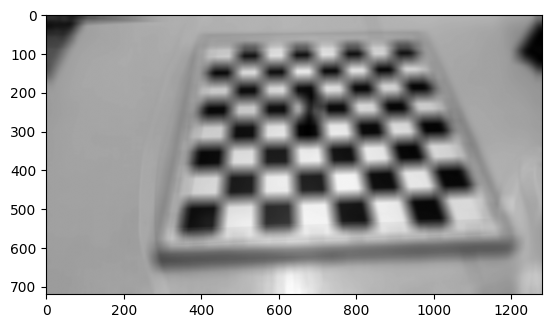

In [5]:
blurred = blurred / np.max(blurred)
plt.imshow(blurred, cmap="gray")
blurred

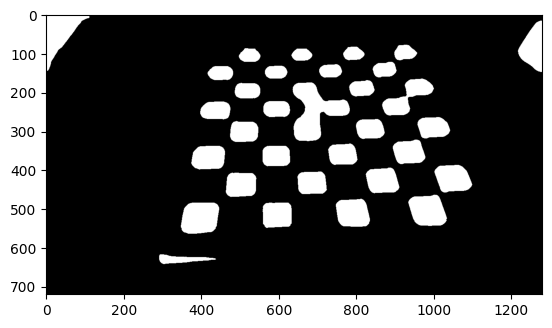

In [6]:
thresh = 0.4
bw = blurred < thresh
plt.imshow(bw, cmap="gray")

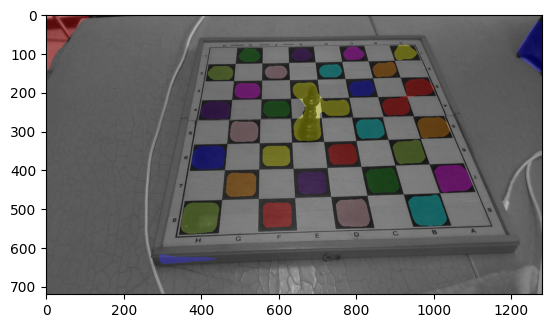

In [7]:
segments = label(bw)
img_label = label2rgb(segments, image=img, bg_label=0)
plt.imshow(img_label)

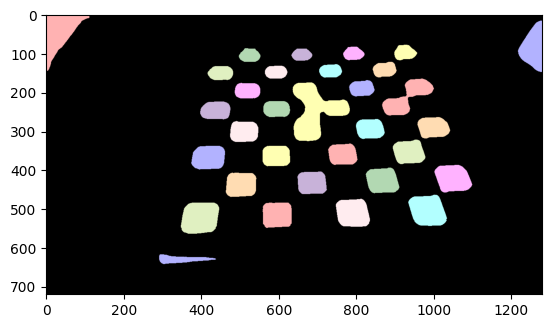

In [8]:
img_label = label2rgb(segments, image=bw, bg_label=0)
plt.imshow(img_label)

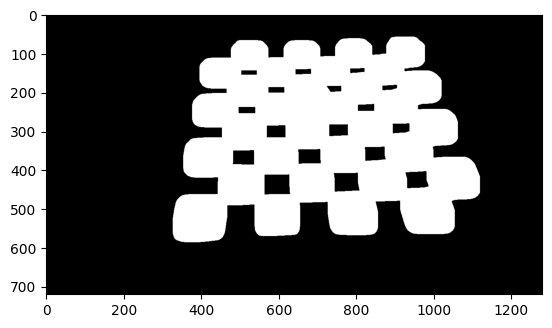

In [27]:
img_new = cv2.cvtColor((img_label * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
blur_amount = 45
img_new = cv2.blur(img_new,(blur_amount, blur_amount))

_, mask_bin = cv2.threshold(img_new, 1, 255, cv2.THRESH_BINARY)

# Find connected components
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_bin)

# Keep only the largest non-background component
largest_component = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
board_mask = np.uint8(labels == largest_component) * 255

plt.imshow(board_mask, cmap="gray")

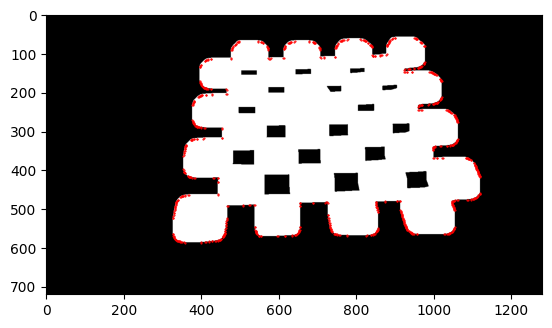

In [28]:
# Binarize (in case it is not already)
_, binary = cv2.threshold(board_mask, 127, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Choose the largest contour (should be the chessboard region)
contour = max(contours, key=cv2.contourArea)

# Extract contour points
points = contour.reshape(-1, 2)

# Optional: visualize
plt.imshow(binary, cmap='gray')
plt.plot(points[:, 0], points[:, 1], 'r.', markersize=1)
plt.show()

In [29]:
from sklearn.linear_model import RANSACRegressor

# Separate top and bottom edge candidates
y_sorted = points[np.argsort(points[:, 1])]
top_points = y_sorted[:len(y_sorted)//4]      # top 25%
bottom_points = y_sorted[-len(y_sorted)//4:]  # bottom 25%

def fit_line_ransac(pts):
    X = pts[:, 0].reshape(-1, 1)
    y = pts[:, 1]
    model = RANSACRegressor().fit(X, y)
    a = model.estimator_.coef_[0]
    b = model.estimator_.intercept_
    return a, b  # y = a*x + b

top_a, top_b = fit_line_ransac(top_points)
bottom_a, bottom_b = fit_line_ransac(bottom_points)

In [30]:
x_sorted = points[np.argsort(points[:, 0])]
left_points = x_sorted[:len(x_sorted)//4]
left_a, left_b = fit_line_ransac(np.flip(left_points, axis=1))  # swap x/y for vertical fit

right_points = x_sorted[-len(x_sorted)//4:]
right_a, right_b = fit_line_ransac(np.flip(right_points, axis=1))  # swap x/y for vertical fit


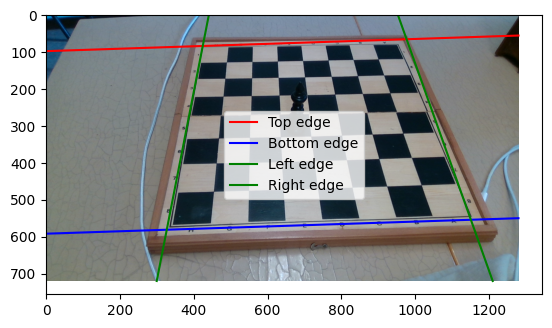

In [31]:
x = np.linspace(0, binary.shape[1], 1000)
plt.imshow(img, cmap='gray')
plt.plot(x, top_a*x + top_b, 'r-', label='Top edge')
plt.plot(x, bottom_a*x + bottom_b, 'b-', label='Bottom edge')

# For left edge, solve x = a*y + b form
y = np.linspace(0, binary.shape[0], 1000)
plt.plot(left_a*y + left_b, y, 'g-', label='Left edge')
plt.plot(right_a*y + right_b, y, 'g-', label='Right edge')

plt.legend()
plt.show()


Top–left: [424.16669346  82.93735354]
Bottom–left: [326.59563997 581.06830843]


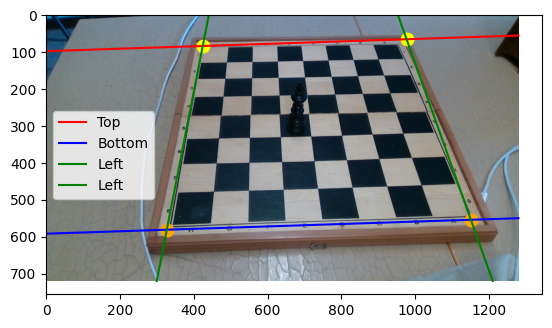

In [36]:
def intersection(a1, b1, a2, b2):
    """Compute intersection (x, y) of two lines y = a1*x + b1 and y = a2*x + b2."""
    x = (b2 - b1) / (a1 - a2)
    y = a1 * x + b1
    return np.array([x, y])

# Convert the left edge line from x = a*y + b to y = (1/a)*x - (b/a)
left_a_y = 1 / left_a
left_b_y = -left_b / left_a
right_a_y = 1 / right_a
right_b_y = -right_b / right_a

# Compute intersections
p_top_left = intersection(top_a, top_b, left_a_y, left_b_y)
p_bottom_left = intersection(bottom_a, bottom_b, left_a_y, left_b_y)
p_top_right = intersection(top_a, top_b, right_a_y, right_b_y)
p_bottom_right = intersection(bottom_a, bottom_b, right_a_y, right_b_y)

intersections = [p_bottom_left, p_bottom_right, p_bottom_left, p_bottom_right]

print("Top–left:", p_top_left)
print("Bottom–left:", p_bottom_left)

plt.imshow(img, cmap='gray')
plt.plot(x, top_a*x + top_b, 'r-', label='Top')
plt.plot(x, bottom_a*x + bottom_b, 'b-', label='Bottom')
plt.plot(left_a*y + left_b, y, 'g-', label='Left')
plt.plot(right_a*y + right_b, y, 'g-', label='Left')
plt.scatter(*p_top_left, color='yellow', s=80)
plt.scatter(*p_bottom_left, color='orange', s=80)
plt.scatter(*p_top_right, color='yellow', s=80)
plt.scatter(*p_bottom_right, color='orange', s=80)
plt.legend()
plt.show()


In [33]:
pts_src = np.float32([p_top_left, p_top_right, p_bottom_right, p_bottom_left])
pts_dst = np.float32([[0, 0], [800, 0], [800, 800], [0, 800]])

M = cv2.getPerspectiveTransform(pts_src, pts_dst)
warped = cv2.warpPerspective(img, M, (800, 800))

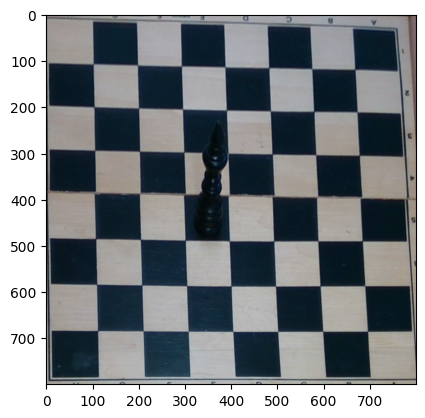

In [34]:
plt.imshow(warped)